# Dgemm trace of a real and complete HPL run

In [1]:
import io
import os
import zipfile
import pandas
import yaml
import datetime
import re
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying warning
import json

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df = pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    df['jobid'] = int(get_yaml(archive_name, 'info.yaml')['jobid'])
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

In [2]:
def __compute_rank_mapping(archive_name, exp_id):
    '''
    Compute the mapping rank-core, based on mpirun output (thanks to the option --report-bindings).
    '''
    history = json.loads(zipfile.ZipFile(archive_name).read('history.json'))
    mpirun = [cmd for cmd in history if cmd['command'].startswith('mpirun') and len(cmd['hostnames']) == 1]
    mpirun = mpirun[exp_id]['stderr'].split('\n')
    regex = re.compile('\[(?P<hostname>[a-z]+-\d+\.[a-z]+\.grid5000\.fr):\d+\] MCW rank (?P<rank>\d+) bound to socket (?P<socket>\d+)\[core (?P<core>\d+)')
    mapping = []
    for line in mpirun:
        match = regex.search(line)
        if match:
            mapping.append({'rank': int(match.group('rank')),
                            'hostname': match.group('hostname'),
                            'socket': int(match.group('socket')),
                            'core': int(match.group('core'))
                           })
    df = pandas.DataFrame(mapping)[['rank', 'hostname', 'socket', 'core']]
    df['node'] = df['hostname'].str[len('dahu-'):-len('.grenoble.grid5000.fr')].astype(int)
    df['cpu'] = df['node']*2 + df['socket'] - 2
    return df.sort_values(by='rank').reset_index(drop=True)

def compute_rank_mapping(archive_name):
    nb_exp = len(read_csv(archive_name, get_yaml(archive_name, 'info.yaml')['expfile'][0]))
    mappings = [__compute_rank_mapping(archive_name, i) for i in range(nb_exp)]
    ref = mappings[0]
    for df in mappings[1:]:
        assert ref.equals(df)
    return ref

In [3]:
# directory = 'dgemm_prediction/2'
# archives = [os.path.join(directory, filename) for filename in os.listdir(directory)]
archives = ['dgemm_prediction/2/grenoble_2019-07-24_1876425.zip']

def __read_archive(archive_name, exp_id):
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    df = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    print('Read trace n°%d from %s: %6d lines' % (exp_id, archive_name, len(df)))
    df['start'] = df.timestamp
    df['end'] = df.timestamp + df.duration
    df = df[['jobid', 'function', 'start', 'end', 'rank', 'm', 'n', 'k', 'duration']]
    df['rank+1'] = df['rank'] + 1
    df['function'] = df['function'].str.strip()
    df['exp_id'] = exp_id
    df['block_size'] = read_csv(archive_name, get_yaml(archive_name, 'info.yaml')['expfile'][0]).iloc[exp_id].block_size
    mapping = compute_rank_mapping(archive_name)
    df = df.set_index('rank').join(mapping.set_index('rank')).reset_index()
    return df

def read_archive(archive_name):
    nb_exp = len(read_csv(archive_name, get_yaml(archive_name, 'info.yaml')['expfile'][0]))
    return pandas.concat([__read_archive(archive_name, i) for i in range(nb_exp)])

traces = [read_archive(filename) for filename in archives]
traces = pandas.concat(traces)

traces = traces[traces['function'] == 'dgemm']
traces.head()

Read trace n°0 from dgemm_prediction/2/grenoble_2019-07-24_1876425.zip: 8617098 lines
Read trace n°1 from dgemm_prediction/2/grenoble_2019-07-24_1876425.zip: 5331887 lines
Read trace n°2 from dgemm_prediction/2/grenoble_2019-07-24_1876425.zip: 4088143 lines


,rank,jobid,function,start,end,m,n,k,duration,rank+1,exp_id,block_size,hostname,socket,core,node,cpu
1,0,1876425,dgemm,0.206168,0.206213,6270.0,2.0,2.0,0.000044,1,0,128,dahu-1.grenoble.grid5000.fr,0,0,1,0
2,0,1876425,dgemm,0.206310,0.206363,6268.0,4.0,4.0,0.000053,1,0,128,dahu-1.grenoble.grid5000.fr,0,0,1,0
3,0,1876425,dgemm,0.206449,0.206469,6266.0,2.0,2.0,0.000020,1,0,128,dahu-1.grenoble.grid5000.fr,0,0,1,0
4,0,1876425,dgemm,0.206545,0.206648,6264.0,8.0,8.0,0.000103,1,0,128,dahu-1.grenoble.grid5000.fr,0,0,1,0
5,0,1876425,dgemm,0.206725,0.206745,6262.0,2.0,2.0,0.000020,1,0,128,dahu-1.grenoble.grid5000.fr,0,0,1,0


In [4]:
traces[['jobid', 'hostname', 'node']].drop_duplicates().sort_values(by=['jobid', 'node']).reset_index(drop=True)

,jobid,hostname,node
0,1876425,dahu-1.grenoble.grid5000.fr,1
1,1876425,dahu-2.grenoble.grid5000.fr,2
2,1876425,dahu-3.grenoble.grid5000.fr,3
3,1876425,dahu-4.grenoble.grid5000.fr,4
4,1876425,dahu-5.grenoble.grid5000.fr,5
5,1876425,dahu-6.grenoble.grid5000.fr,6
6,1876425,dahu-8.grenoble.grid5000.fr,8
7,1876425,dahu-9.grenoble.grid5000.fr,9
8,1876425,dahu-10.grenoble.grid5000.fr,10
9,1876425,dahu-11.grenoble.grid5000.fr,11


## HPL result

In [5]:
res = pandas.concat([read_csv(filename, 'results.csv') for filename in archives])
res[['jobid', 'matrix_size', 'block_size', 'time']].sort_values(by='matrix_size')

,jobid,matrix_size,block_size,time
0,1876425,200000,128,438.69
1,1876425,200000,256,487.73
2,1876425,200000,512,544.12


## Checking the parameters

In [6]:
pandas.concat([read_csv(filename, 'exp_smaller.csv') for filename in archives])

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process,jobid
0,200000,128,32,16,1,2,2,1,0,8,32,1,1876425
1,200000,256,32,16,1,2,2,1,0,8,32,1,1876425
2,200000,512,32,16,1,2,2,1,0,8,32,1,1876425


## Prediction error on the duration

In [7]:
stat_file = '/tmp/stats.csv'
!wget https://gitlab.in2p3.fr/tom.cornebize/g5k_data/raw/master/stats.csv -O {stat_file}
stats = pandas.read_csv(stat_file)
min_epoch = int(datetime.datetime.timestamp(datetime.datetime(2019, 7, 4)))
max_epoch = int(datetime.datetime.timestamp(datetime.datetime(2019, 7, 5)))
stats = stats[(stats['start_time'] > min_epoch) & (stats['start_time'] < max_epoch) & (stats['cluster'] == 'dahu')]
stats['cpu'] = stats['node']*2 + stats['cpu'] - 2
print(len(stats))
stats.head()

--2019-07-25 13:37:24--  https://gitlab.in2p3.fr/tom.cornebize/g5k_data/raw/master/stats.csv
Résolution de gitlab.in2p3.fr… 134.158.69.41
Connexion à gitlab.in2p3.fr|134.158.69.41|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 1973486 (1,9M) [text/plain]
Sauvegarde en : « /tmp/stats.csv »

/tmp/stats.csv      100%[===================>]   1,88M  --.-KB/s    ds 0,04s   

2019-07-25 13:37:25 (47,3 MB/s) — « /tmp/stats.csv » sauvegardé [1973486/1973486]

64


,function,cluster,node,cpu,jobid,start_time,expfile_hash,avg_gflops,intercept,intercept_residual,...,nk,nk_residual,tvalue_mk,tvalue_mk_residual,tvalue_mn,tvalue_mn_residual,tvalue_mnk,tvalue_mnk_residual,tvalue_nk,tvalue_nk_residual
906,dgemm,dahu,8,14,1872794,1562253596,cf32520fd5a1fba35b2aef2115176cc4fc122f6cff4deb...,29.411034,0.000002,2.663016e-07,...,3.090713e-09,3.021082e-12,54.476653,4.088793,5.882608,1.158967,803.873722,28.583488,90.088043,0.536700
907,dgemm,dahu,8,15,1872794,1562253596,cf32520fd5a1fba35b2aef2115176cc4fc122f6cff4deb...,29.937655,0.000002,2.998226e-07,...,3.130368e-09,2.692329e-11,64.537640,7.550601,6.691685,1.514226,980.436894,15.627361,113.322230,9.122559
908,dgemm,dahu,9,16,1872795,1562253596,cf32520fd5a1fba35b2aef2115176cc4fc122f6cff4deb...,29.869229,0.000002,3.490054e-07,...,3.091349e-09,3.335459e-11,65.893017,8.494052,6.804481,0.799481,1000.791409,15.193153,113.893371,11.086900
909,dgemm,dahu,9,17,1872795,1562253596,cf32520fd5a1fba35b2aef2115176cc4fc122f6cff4deb...,29.936732,0.000002,3.180082e-07,...,3.084816e-09,2.859961e-11,65.921716,9.661060,6.792235,1.376712,1006.443702,23.944741,114.536584,14.429766
910,dgemm,dahu,1,0,1872787,1562253701,cf32520fd5a1fba35b2aef2115176cc4fc122f6cff4deb...,28.005161,0.000002,3.568280e-07,...,3.059798e-09,5.660122e-11,52.537827,1.342221,5.083726,0.406870,779.574051,19.143585,82.109109,6.597297


In [8]:
traces['pred'] = 0
traces['mnk'] = traces.m * traces.n * traces.k
traces['mn'] = traces.m * traces.n
traces['mk'] = traces.m * traces.k
traces['nk'] = traces.n * traces.k
for cpu in traces['cpu'].unique():
    reg = stats[stats['cpu'] == cpu]
    assert len(reg) == 1
    reg = list(reg.iterrows())[0][1]
    traces.loc[traces['cpu'] == cpu, 'pred'] += reg['intercept']
    for prod in ['mnk', 'mn', 'mk', 'nk']:
        traces.loc[traces['cpu'] == cpu, 'pred'] += reg[prod] * traces[traces['cpu'] == cpu][prod]

In [9]:
traces['error'] = (traces['pred'] - traces['duration']) / traces['duration']
traces['abs_error'] = traces['error'].abs()
tmp = traces[(traces['abs_error'] > 0.1) & (traces['duration'] > 0.1)]
print(len(tmp))
tmp_nonerror = traces[(traces['abs_error'] < 0.1) & (traces['duration'] > 0.1)].sample(n=len(tmp))
tmp.sort_values(by='abs_error', axis=0, ascending=False).head()

271684


,rank,jobid,function,start,end,m,n,k,duration,rank+1,...,core,node,cpu,pred,mnk,mn,mk,nk,error,abs_error
1623895,203,1876425,dgemm,298.9139,299.023950,4608.0,512.0,512.0,0.110050,204,...,11,8,14,0.081927,1.207960e+09,2359296.0,2359296.0,262144.0,-0.255547,0.255547
1572237,197,1876425,dgemm,241.0206,241.130321,4608.0,512.0,512.0,0.109721,198,...,5,8,14,0.081927,1.207960e+09,2359296.0,2359296.0,262144.0,-0.253317,0.253317
1631911,204,1876425,dgemm,298.9196,299.029185,4608.0,512.0,512.0,0.109585,205,...,12,8,14,0.081927,1.207960e+09,2359296.0,2359296.0,262144.0,-0.252392,0.252392
1009441,124,1876425,dgemm,298.8647,298.972032,4608.0,512.0,512.0,0.107332,125,...,28,4,7,0.080716,1.207960e+09,2359296.0,2359296.0,262144.0,-0.247983,0.247983
1646633,206,1876425,dgemm,241.1593,241.267870,4608.0,512.0,512.0,0.108570,207,...,14,8,14,0.081927,1.207960e+09,2359296.0,2359296.0,262144.0,-0.245398,0.245398


In [10]:
traces[traces.duration > 0.1]['error'].describe()

count    1.017334e+06
mean    -7.055148e-02
std      3.938736e-02
min     -2.555473e-01
25%     -1.023124e-01
50%     -7.045798e-02
75%     -3.930669e-02
max      1.137377e-01
Name: error, dtype: float64

In [11]:
melted = tmp.melt(id_vars=['jobid', 'block_size', 'hostname', 'cpu', 'm', 'n', 'k', 'mnk', 'mn', 'mk', 'nk', 'start', 'error'], value_vars=['duration', 'pred'], var_name='kind', value_name='time')
melted_nonerror = tmp_nonerror.melt(id_vars=['jobid', 'block_size', 'hostname', 'cpu', 'm', 'n', 'k', 'mnk', 'mn', 'mk', 'nk', 'start', 'error'], value_vars=['duration', 'pred'], var_name='kind', value_name='time')
melted['gflops'] = 2*melted['mnk'] / melted['time'] * 1e-9
melted_nonerror['gflops'] = 2*melted_nonerror['mnk'] / melted_nonerror['time'] * 1e-9

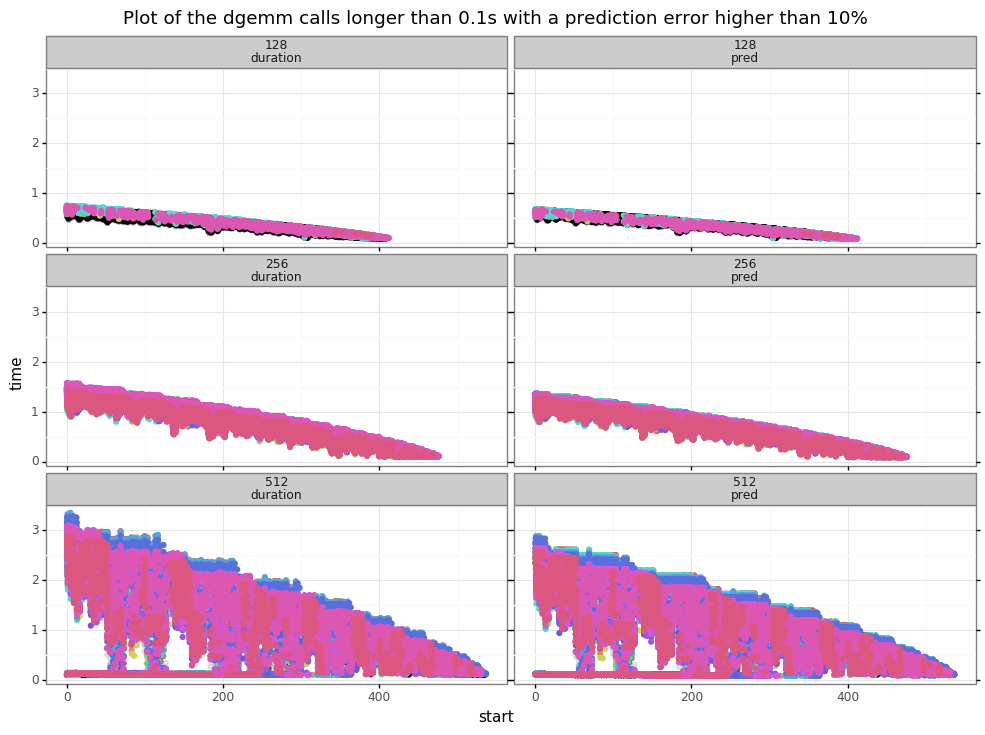

<ggplot: (8752709911451)>


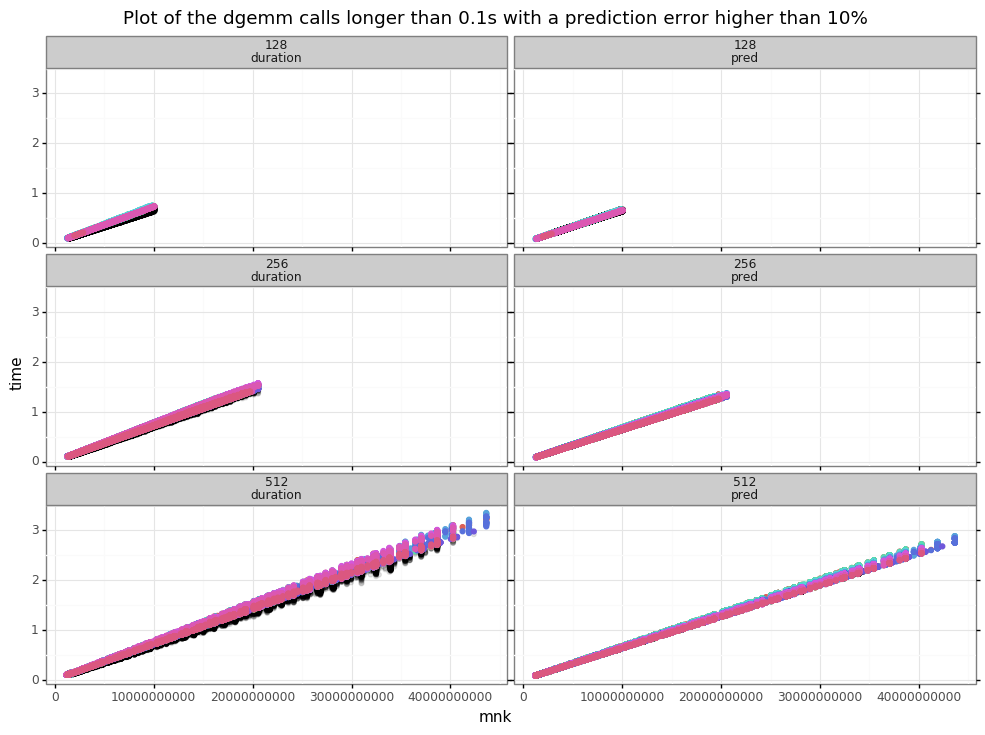

<ggplot: (8752694761974)>


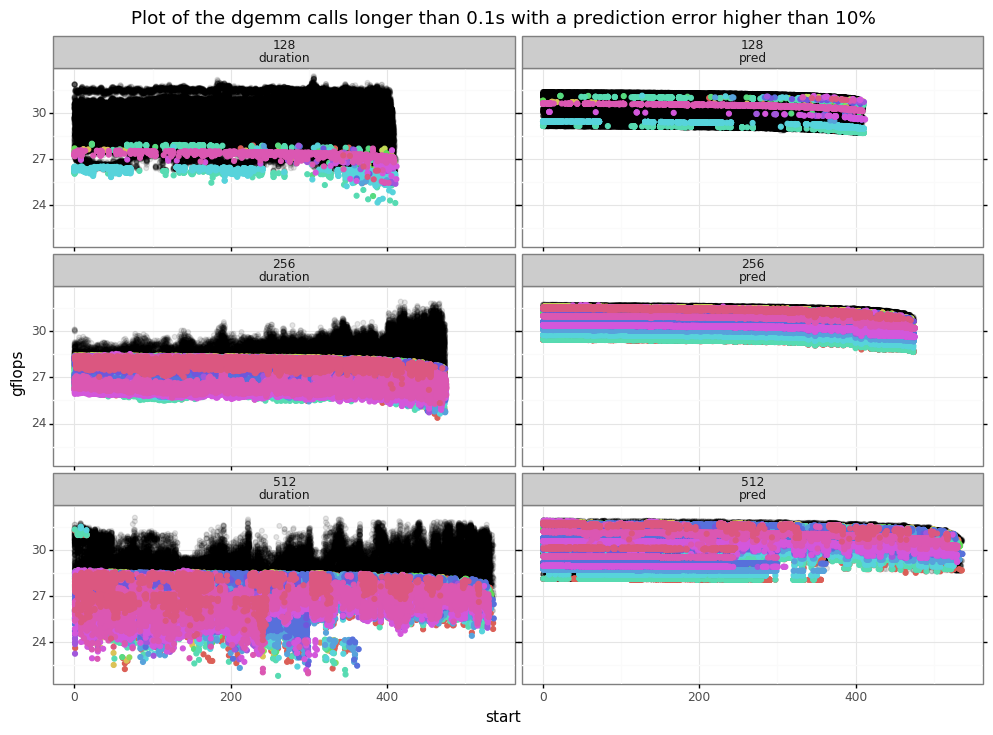

<ggplot: (-9223363284172134354)>


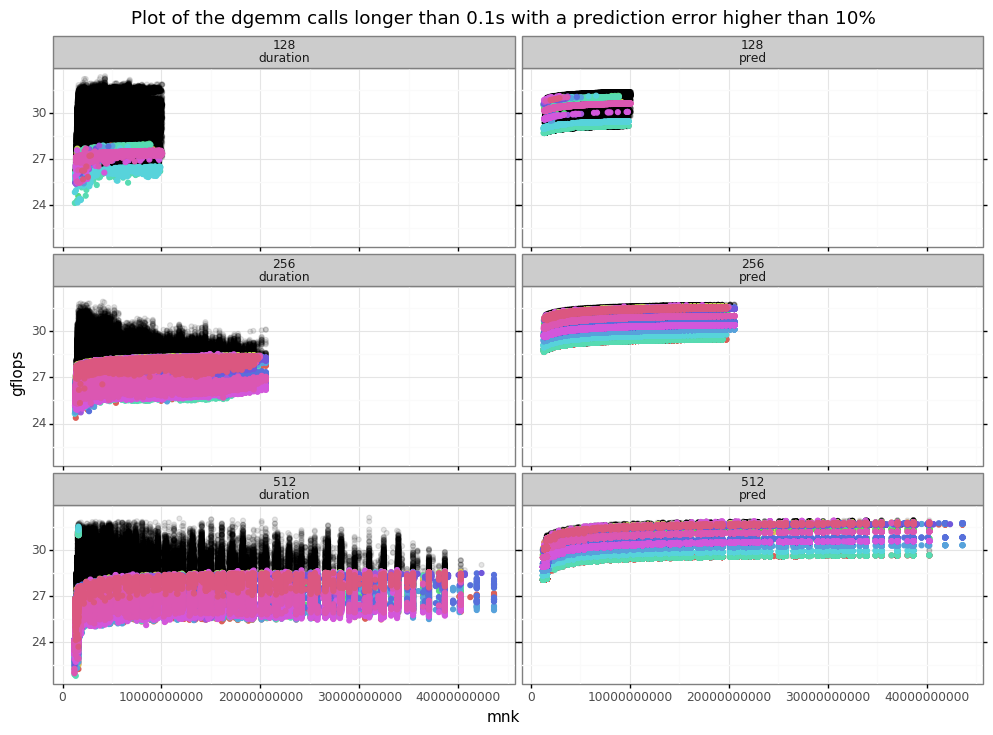

<ggplot: (8752696042637)>


In [12]:
p = ggplot(melted, aes(color='factor(hostname)')) + theme_bw() + facet_wrap(['block_size', 'kind'], ncol=2)
p = p + theme(legend_position='none') + ggtitle('Plot of the dgemm calls longer than 0.1s with a prediction error higher than 10%')
for y in ['time', 'gflops']:
    for x in ['start', 'mnk']:
        print(p + geom_point(melted_nonerror, aes(x=x, y=y), color='black', alpha=0.1) + geom_point(aes(x=x, y=y)))

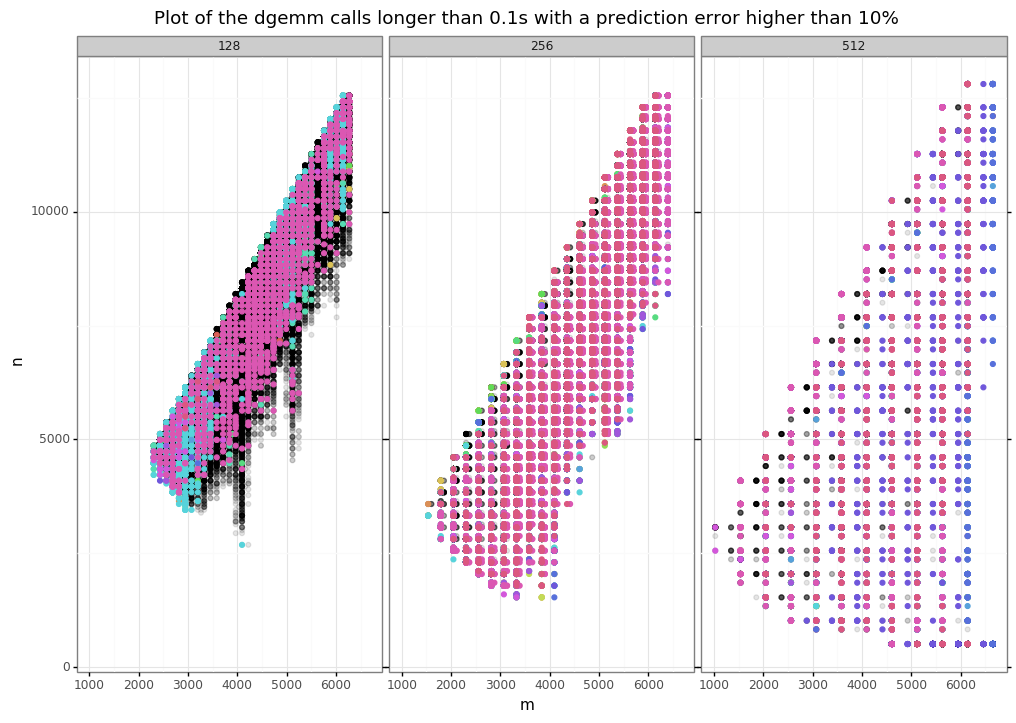

<ggplot: (8752685016454)>


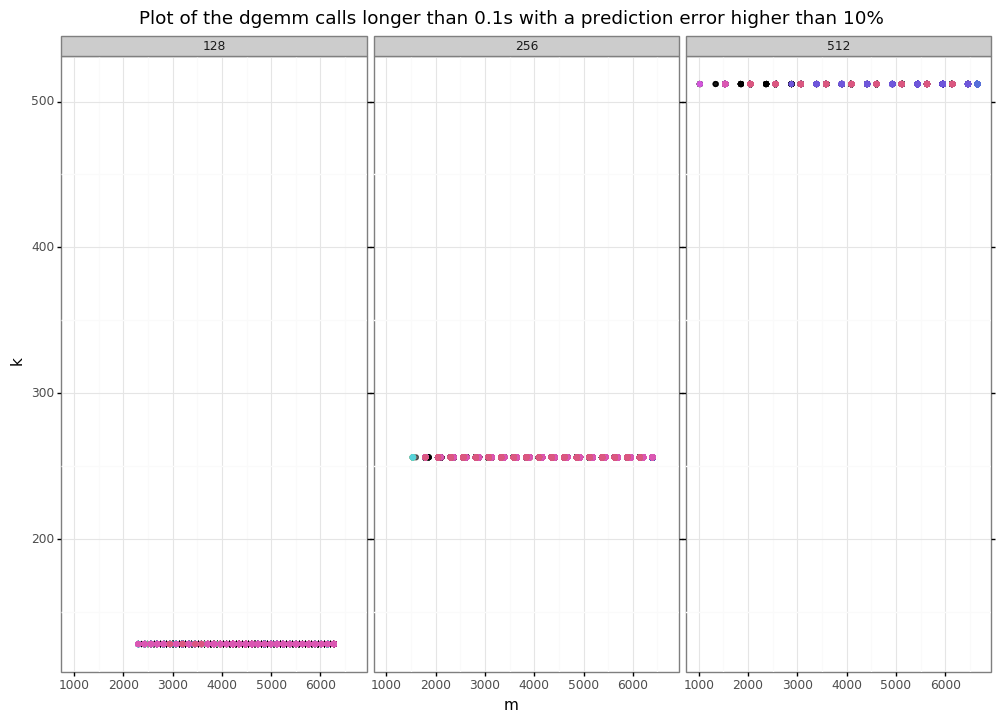

<ggplot: (-9223363284172134838)>


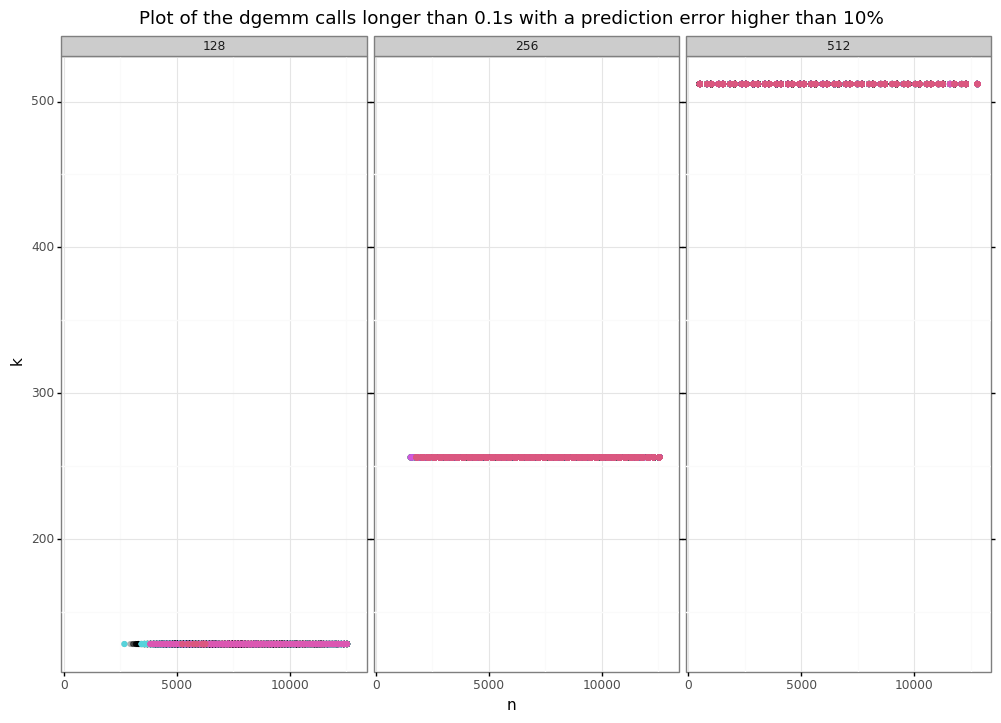

<ggplot: (-9223363284147526775)>


In [13]:
p = ggplot(tmp, aes(color='factor(hostname)')) + theme_bw() + facet_wrap(['block_size'], ncol=3)
p = p + theme(legend_position='none') + ggtitle('Plot of the dgemm calls longer than 0.1s with a prediction error higher than 10%')
for x, y in ['mn', 'mk', 'nk']:
    print(p + geom_point(tmp_nonerror, aes(x=x, y=y), color='black', alpha=0.1) + geom_point(aes(x=x, y=y)))

In [14]:
summary = traces.groupby(['block_size', 'hostname', 'node', 'socket', 'cpu', 'rank'])[['duration', 'pred', 'mnk']].sum().reset_index()
summary['gflops_real'] = 2*summary['mnk'] / summary['duration'] * 1e-9
summary['gflops_pred'] = 2*summary['mnk'] / summary['pred'] * 1e-9
summary['error'] = (summary['pred'] - summary['duration']) / summary['duration']
summary['abs_error'] = summary['error'].abs()
summary.sort_values(by='abs_error', ascending=False).head(n=10)

,block_size,hostname,node,socket,cpu,rank,duration,pred,mnk,gflops_real,gflops_pred,error,abs_error
965,256,dahu-8.grenoble.grid5000.fr,8,0,14,197,409.016748,351.712576,5.359231e+12,26.205435,30.475060,-0.140102,0.140102
963,256,dahu-8.grenoble.grid5000.fr,8,0,14,195,408.277797,351.162688,5.338259e+12,26.150134,30.403341,-0.139893,0.139893
964,256,dahu-8.grenoble.grid5000.fr,8,0,14,196,408.579187,351.600122,5.348745e+12,26.182172,30.425161,-0.139457,0.139457
968,256,dahu-8.grenoble.grid5000.fr,8,0,14,200,410.216941,353.601606,5.390688e+12,26.282134,30.490180,-0.138013,0.138013
969,256,dahu-8.grenoble.grid5000.fr,8,0,14,201,410.713548,354.385124,5.401174e+12,26.301416,30.481945,-0.137148,0.137148
971,256,dahu-8.grenoble.grid5000.fr,8,0,14,203,412.207200,355.784059,5.422146e+12,26.307864,30.479980,-0.136881,0.136881
970,256,dahu-8.grenoble.grid5000.fr,8,0,14,202,411.732489,355.527797,5.411660e+12,26.287261,30.442963,-0.136508,0.136508
974,256,dahu-8.grenoble.grid5000.fr,8,0,14,206,404.003893,349.078988,5.286461e+12,26.170349,30.288053,-0.135951,0.135951
973,256,dahu-8.grenoble.grid5000.fr,8,0,14,205,408.553465,353.221914,5.318568e+12,26.036091,30.114595,-0.135433,0.135433
975,256,dahu-8.grenoble.grid5000.fr,8,0,14,207,405.628397,350.703310,5.296528e+12,26.115172,30.205177,-0.135407,0.135407


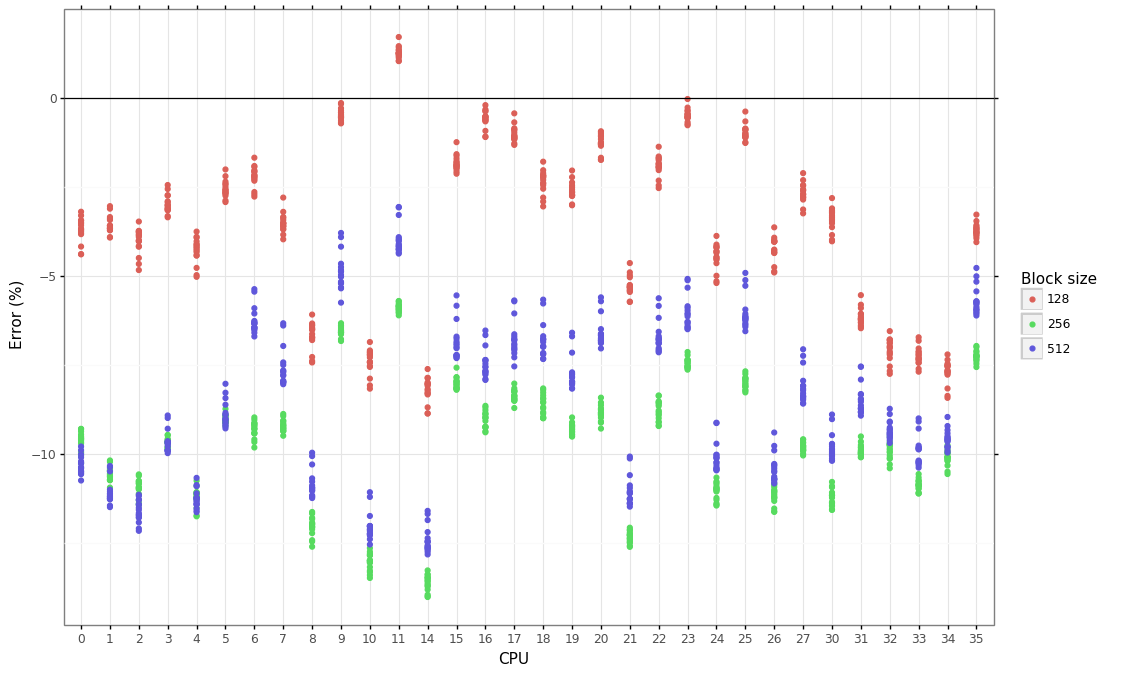

<ggplot: (8752682672069)>

In [15]:
tmp = summary.copy()
tmp['error'] *= 100
plot = ggplot(tmp, aes(x='factor(cpu)', y='error', color='factor(block_size)')) + geom_point() + theme_bw()
plot = plot + geom_hline(yintercept=0) + ylab('Error (%)') + xlab('CPU') + labs(color='Block size')
plot

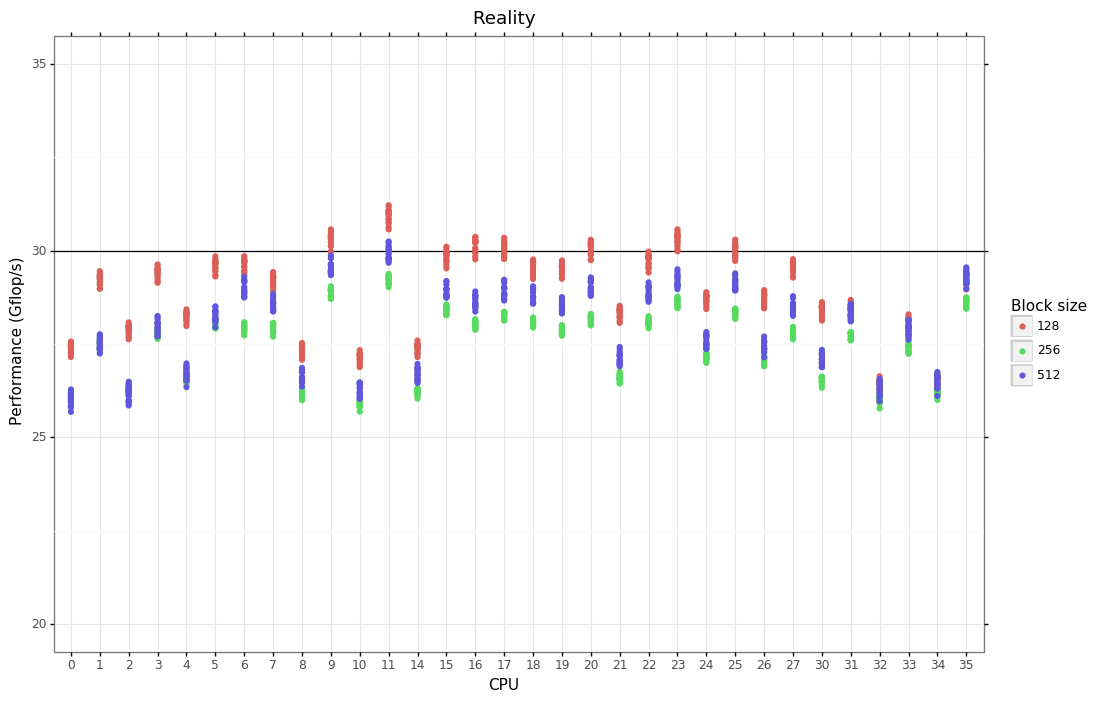

<ggplot: (-9223363284172140691)>


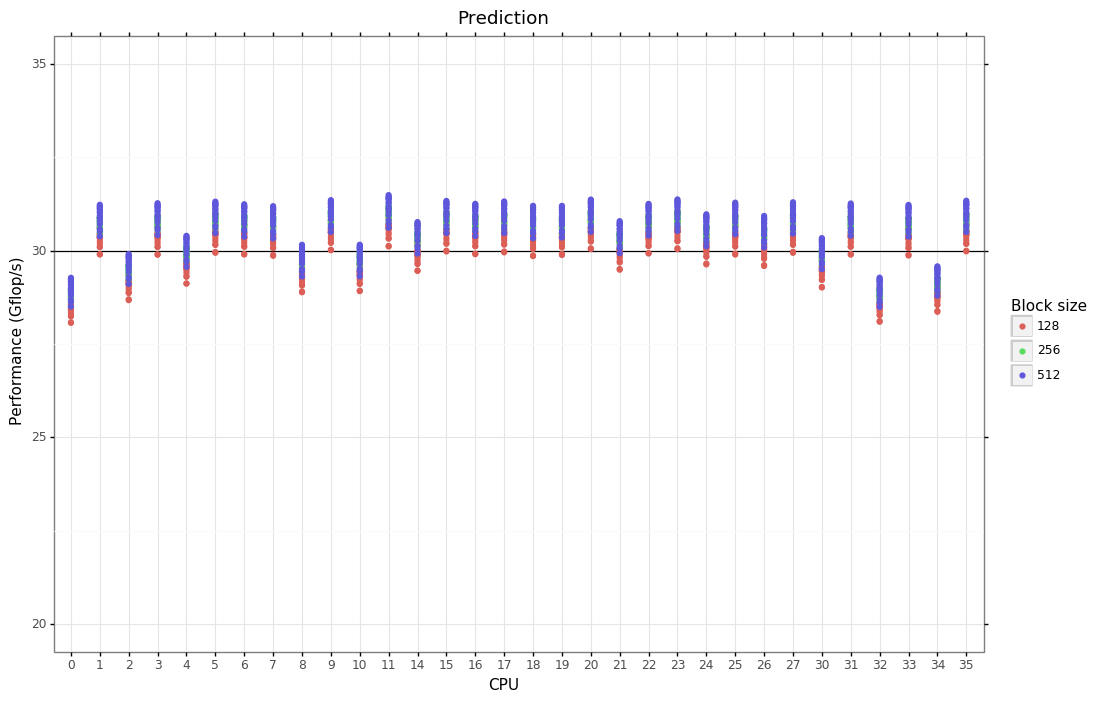

<ggplot: (-9223363284169282630)>


In [16]:
plot = ggplot(tmp, aes(x='factor(cpu)', color='factor(block_size)')) + theme_bw()
plot = plot + geom_hline(yintercept=30) + ylab('Performance (Gflop/s)') + xlab('CPU') + labs(color='Block size') + expand_limits(y=20) + expand_limits(y=35)
print(plot + geom_point(aes(y='gflops_real')) + ggtitle('Reality'))
print(plot + geom_point(aes(y='gflops_pred')) + ggtitle('Prediction'))

In [17]:
dump = traces[(traces['rank'] == 0) & (traces['block_size'] == 512)].sort_values(by='start', axis=0)[['function', 'm', 'n', 'k']]
dump.m = dump.m.astype('int')
dump.n = dump.n.astype('int')
dump.k = dump.k.astype('int')
dump.to_csv('/tmp/exp_hpl.csv', index=False, header=False)